# Comunidad energética:

## Importar

In [1]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Lectura de datos

In [2]:
# Lectura datos del mix energético seleccionado de 7 consumidores (ya en kW)

archivos_demanda = {
    "C2": "Commercial-450-bed Hospital.csv",
    "C8": "Commercial-Supermarket.csv",
    "C9": "Commercial-Wastewater Treatment Plant.csv",
    "C11": "Industrial-2-shift Fabricated Metals.csv",
    "C15": "Industrial-Plastic Manufacturer.csv",
    "C19": "Reference-Hotel.csv",
    "C21": "Reference-Residental.csv"
}

# Lectura de datos de generación solar de PVGis (W)

archivos_solar = {
    "Esparragosa": "PRODUCCION SOLAR ESPARRAGOSA.csv",
    "Helsinki": "PRODUCCION SOLAR HELSINKI.csv"
}
 
# lectura de datos del precio de mercado de la energía (Pool 2023 €/MWh)

archivos_precios = {
    "Precio_Esp": "GUI_ENERGY_PRICES_ESPAÑA_PENINSULA2023.csv",
    "Precio_Fin": "GUI_ENERGY_PRICES_FINLANDIA2023.csv"
}

## Limpieza y procesamiento de datos

In [3]:
# funciones para lectura y procesado

def leer_demanda_consumidor(archivo):
    """Lee el consumo del cliente (en kW) y genera su estampa temporal directamente en UTC"""
    # Leemos el archivo saltando la primera fila de texto
    df = pd.read_csv(archivo, header=0)
    df.columns = ['demanda_kw'] # Nos aseguramos de que la columna se llame así
    
    # Como el CSV no trae fechas, generamos las 8760 horas del año 2023 en UTC
    df['datetime'] = pd.date_range(start="2023-01-01 00:00:00", periods=len(df), freq='h', tz='UTC')
    
    return df[['datetime', 'demanda_kw']]

def leer_generacion_pvgis(archivo):
    """Lee PVGis, salta cabecera y convierte W a kW"""
    # Saltamos las 11 filas de metadatos de PVGis
    df = pd.read_csv(archivo, skiprows=10, nrows=8760)
    
    # Esto es vital para que coincida con el precio y la demanda
    df['datetime'] = (pd.to_datetime(df['time'], format='%Y%m%d:%H%M')
                      .dt.floor('h') # Normalizamos el tiempo 20230101:0010 a la hora en punto (00:00)
                      .dt.tz_localize('UTC')) # Marcamos que estos datos son UTC
    
    # Dividimos por 1.000 para pasar de W a kW.
    # El archivo de PVGis ya viene para 1 kWp, así que no hace falta dividir por otros 1.000 adicionales.
    df['p_solar_kw'] = df['P'] / 10**3
    
    return df[['datetime', 'p_solar_kw']]

    
def leer_precio_mayorista(archivo):
    """Lee el Pool (Precio Mayorista), convierte EUR/MWh a EUR/kWh y lo convierte a UTC"""
    df = pd.read_csv(archivo)
    
    # Antes de convertir el tiempo, nos quedamos con el inicio de la hora
    # El split separa "01/01/2023 00:00:00 - 01/01/2023 01:00:00" y coge la primera parte en una temporal
    temp_dt = df['MTU (CET/CEST)'].str.split(' - ').str[0]

    # Limpieza clave, quitamos "(CET)" o "(CEST)" si aparecen en el texto (cambios de hora) para que no de error luego
    temp_dt = temp_dt.str.replace(' (CET)', '', regex=False).str.replace(' (CEST)', '', regex=False)

    # Ahora que está limpio, convertimos a datetime y Lo mueve a UTC para que coincida con solar y demanda
    df['datetime'] = (pd.to_datetime(temp_dt, dayfirst=True)
                      .dt.tz_localize('CET', ambiguous='infer') # Identifica cuál de las dos horas de octubre es la repetida
                      .dt.tz_convert('UTC'))
    
    # Cambio de unidad: EUR/MWh -> EUR/kWh (Dividimos por 1000)
    df['pool_eur_kwh'] = df['Day-ahead Price (EUR/MWh)'] / 1000
    
    return df[['datetime', 'pool_eur_kwh']]



# suma de las demandas de los consumidores

df_demanda_total = None

for nombre, ruta in archivos_demanda.items():
    df_aux = leer_demanda_consumidor(ruta)
    
    if df_demanda_total is None:
        # Inicializamos con el datetime y la primera columna con su ID (ej: C2)
        df_demanda_total = df_aux.rename(columns={'demanda_kw': nombre})
    else:
        # Añadimos la columna del nuevo consumidor al dataframe existente
        df_demanda_total[nombre] = df_aux['demanda_kw'].values

# Una vez que tenemos todas las columnas individuales, creamos la suma total
# que necesitan las funciones de medoides y modelos
ids_consumidores = list(archivos_demanda.keys())
df_demanda_total['demanda_kw'] = df_demanda_total[ids_consumidores].sum(axis=1)


# El año 2023 tiene 8760 horas
# En marzo (domingo 26): A las 02:00 AM pasaron a ser las 03:00 AM. Esa hora (las 02:00 CET) no existe en los registros locales de precios
# El problema, al usar un merge de tipo inner, cuando el programa busca la correspondencia de esa hora de marzo en el archivo de precios y no la encuentra (porque no existe), borra la fila entera de la demanda y del solar para esa hora.

# procesado de España

df_solar_esp = leer_generacion_pvgis(archivos_solar["Esparragosa"])
df_precio_esp = leer_precio_mayorista(archivos_precios["Precio_Esp"])
# unimos todo para España
df_espana = pd.merge(df_demanda_total, df_solar_esp, on='datetime', how='left')
df_espana = pd.merge(df_espana, df_precio_esp, on='datetime', how='left')

# procesado de Finlandia

df_solar_fin = leer_generacion_pvgis(archivos_solar["Helsinki"])
df_precio_fin = leer_precio_mayorista(archivos_precios["Precio_Fin"])
# unimos todo para Finlandia
df_finlandia = pd.merge(df_demanda_total, df_solar_fin, on='datetime', how='left')
df_finlandia = pd.merge(df_finlandia, df_precio_fin, on='datetime', how='left')

# comprobación
print(f"Filas España: {len(df_espana)} | Filas Finlandia: {len(df_finlandia)}")

Filas España: 8760 | Filas Finlandia: 8760


## Cálculo de periodos y precios finales

In [4]:
# --- PARÁMETROS ESPAÑA (6.1TD Peninsula) ---
PEAJES_61TD = {
    "P1": 0.031327, "P2": 0.024220, "P3": 0.011251,
    "P4": 0.007036, "P5": 0.002024, "P6": 0.001437
}

# He cambiado el nombre a FESTIVOS_P6_2023
FESTIVOS_P6_2023 = [
    '2023-01-06', '2023-04-07', '2023-05-01', '2023-08-15', 
    '2023-10-12', '2023-11-01', '2023-12-06', '2023-12-08', '2023-12-25'
]

# MAG (Tope al gas) en €/kWh. 
# En 2023 el MAG bajó bajó a 0 después de febrero.
MAG_2023 = {1: 0.00189, 2: 0.00018} 

# --- PARÁMETROS FINLANDIA ---
PEAJE_HELEN_DIA = 0.0115    # Lun-Sab (07-22h)
PEAJE_HELEN_NOCHE = 0.0075  # Resto y Domingos
IMPUESTO_CLASE_II = 0.00063


def obtener_periodo_61TD(dt_utc):
    """Convierte UTC a Local Madrid y asigna periodo P1-P6"""
    # Convertir a hora local para saber el periodo real
    dt = dt_utc.tz_convert('Europe/Madrid')
    
    # Fines de semana y festivos son P6
    if dt.weekday() >= 5 or dt.strftime('%Y-%m-%d') in FESTIVOS_P6_2023:
        return "P6"
    
    # Horas nocturnas (00:00 a 08:00 local) son P6
    if 0 <= dt.hour < 8:
        return "P6"
    
    mes, hora = dt.month, dt.hour
    
    # Identificar Temporada (Península)
    if mes in [1, 2, 7, 12]: temporada = "A"
    elif mes in [3, 11]: temporada = "B"
    elif mes in [6, 8, 9]: temporada = "B1"
    else: temporada = "C" # 4, 5, 10
    
    # Asignar Periodo según horas oficiales 6.1TD
    # Punta: 10-14 y 18-22
    if (10 <= hora < 14) or (18 <= hora < 22):
        mapping = {"A": "P1", "B": "P2", "B1": "P3", "C": "P4"}
        return mapping[temporada]
    # Llano: 08-10, 14-18, 22-24
    elif (8 <= hora < 10) or (14 <= hora < 18) or (22 <= hora < 24):
        mapping = {"A": "P2", "B": "P3", "B1": "P4", "C": "P5"}
        return mapping[temporada]
    
    return "P6"

def calcular_precio_final_esp(row):
    """P_ES = (Pool + MAG + Peaje) * IEE * IVA"""
    dt_utc = row['datetime']
    mag_kwh = MAG_2023.get(dt_utc.month, 0.0)
    
    periodo = obtener_periodo_61TD(dt_utc)
    peaje = PEAJES_61TD[periodo]
    
    # IEE 2023 (0.5% aprox -> 1.005) e IVA (21% -> 1.21)
    return (row['pool_eur_kwh'] + mag_kwh + peaje) * 1.005 * 1.21

def calcular_precio_final_fin(row):
    """P_FI = (Pool + Peaje + Impuesto) * IVA_FI"""
    # Convertir UTC a hora local de Helsinki
    dt = row['datetime'].tz_convert('Europe/Helsinki')
    
    # Lógica Helen L (Día: Lun-Sab 07-22h hora local)
    if dt.weekday() < 6 and 7 <= dt.hour < 22:
        peaje = PEAJE_HELEN_DIA
    else:
        peaje = PEAJE_HELEN_NOCHE
        
    return (row['pool_eur_kwh'] + peaje + IMPUESTO_CLASE_II) * 1.24




# Aplicar precios finales
df_espana['precio_final_kwh'] = df_espana.apply(calcular_precio_final_esp, axis=1)
df_finlandia['precio_final_kwh'] = df_finlandia.apply(calcular_precio_final_fin, axis=1)

## Comprobaciones

In [5]:
def auditoria_datos(df_esp, df_fin):
    print("--- AUDITORÍA DE DATOS ---")
    
    # TEST 1: El lunes 2 de enero a las 11:00 (Hora Punta P1 en España)
    # En UTC, las 11:00 de Madrid son las 10:00 UTC (invierno)
    test_p1 = df_esp[df_esp['datetime'] == '2023-01-02 10:00:00+00:00']
    
    # TEST 2: El cambio de hora de Verano (26 de Marzo)
    # Comprobar que no hay saltos extraños
    test_marzo = df_esp[(df_esp['datetime'] >= '2023-03-26 00:00:00+00:00') & 
                        (df_esp['datetime'] <= '2023-03-26 04:00:00+00:00')]

    # TEST 3: Alineación Solar (¿Cuándo es el máximo de producción?)
    max_solar_esp = df_esp.loc[df_esp['p_solar_kw'].idxmax()]
    max_solar_fin = df_fin.loc[df_fin['p_solar_kw'].idxmax()]

    print(f"\n1. TEST PUNTA (España - Lun 2 Ene 11:00h Local):")
    if not test_p1.empty:
        p_final = test_p1['precio_final_kwh'].values[0]
        pool = test_p1['pool_eur_kwh'].values[0]
        print(f"   - Pool: {pool:.4f} €/kWh | Precio Final: {p_final:.4f} €/kWh")
        print(f"   - Incremento: {((p_final/(pool+0.00001))-1)*100:.1f}% (Debe ser alto por P1 + Impuestos)")

    print(f"\n2. TEST MARZO (Cambio de hora):")
    print(f"   - Filas encontradas: {len(test_marzo)} (Deberían ser 5 si todo es lineal en UTC)")

    print(f"\n3. TEST SOLAR (Máxima producción):")
    print(f"   - España: {max_solar_esp['datetime']} (Debe ser mediodía en UTC, ~11:00-13:00)")
    print(f"   - Finlandia: {max_solar_fin['datetime']}")
    
    # TEST 4: ¿Hay valores vacíos?
    print(f"\n4. VALORES NULOS:")
    print(f"   - NaNs en España: {df_esp.isna().sum().sum()}")
    print(f"   - NaNs en Finlandia: {df_fin.isna().sum().sum()}")



# ffill() arregla los huecos intermedios, bfill() arregla si el hueco es la primera fila para eliminar los 2 valores NaNs
df_espana = df_espana.ffill().bfill()
df_finlandia = df_finlandia.ffill().bfill()


auditoria_datos(df_espana, df_finlandia)

--- AUDITORÍA DE DATOS ---

1. TEST PUNTA (España - Lun 2 Ene 11:00h Local):
   - Pool: 0.1261 €/kWh | Precio Final: 0.1937 €/kWh
   - Incremento: 53.6% (Debe ser alto por P1 + Impuestos)

2. TEST MARZO (Cambio de hora):
   - Filas encontradas: 5 (Deberían ser 5 si todo es lineal en UTC)

3. TEST SOLAR (Máxima producción):
   - España: 2023-02-27 13:00:00+00:00 (Debe ser mediodía en UTC, ~11:00-13:00)
   - Finlandia: 2023-05-07 10:00:00+00:00

4. VALORES NULOS:
   - NaNs en España: 0
   - NaNs en Finlandia: 0


## Simplifación de datos con semanas representativas

In [6]:
# Calcular 4 semanas representativas por estaciones, en vez de medias, medoides

def calcular_medoides_estacionales(df_base):
    # Alineación al primer lunes (02/01/2023)
    fecha_inicio = pd.to_datetime('2023-01-02 00:00:00').tz_localize('UTC')
    df_alineado = df_base[df_base['datetime'] >= fecha_inicio].copy()
    df_alineado = df_alineado.reset_index(drop=True)
    
    df_alineado['semana_idx'] = df_alineado.index // 168
    
    estaciones = {
        "Invierno": [12, 1, 2],
        "Primavera": [3, 4, 5],
        "Verano": [6, 7, 8],
        "Otoño": [9, 10, 11]
    }
    
    cols_analisis = ['demanda_kw', 'p_solar_kw', 'precio_final_kwh']
    
    # Normalización para que el error sea comparable
    df_norm = df_alineado.copy()
    for col in cols_analisis:
        df_norm[col] = (df_norm[col]-df_norm[col].min())/(df_norm[col].max()-df_norm[col].min())

    medoides = {}
    print("--- CÁLCULO DE MEDOIDES (LUNES A DOMINGO) ---")
    for nombre, meses in estaciones.items():
        df_est_norm = df_norm[df_norm['datetime'].dt.month.isin(meses)]
        perfil_objetivo = df_est_norm.groupby(df_est_norm['datetime'].dt.hour)[cols_analisis].mean()
        
        min_error = float('inf')
        mejor_semana_idx = None
        
        for num_semana, datos_semana in df_est_norm.groupby('semana_idx'):
            if len(datos_semana) < 168: continue
            perfil_semana = datos_semana.groupby(datos_semana['datetime'].dt.hour)[cols_analisis].mean()
            
            # Cálculo del error (Distancia cuadrática)
            error = ((perfil_semana - perfil_objetivo)**2).sum().sum()
            
            if error < min_error:
                min_error = error
                mejor_semana_idx = num_semana
        
        # Guardar resultado
        medoides[nombre] = df_alineado[df_alineado['semana_idx'] == mejor_semana_idx].copy()
        
        # Print de control
        inicio_dt = medoides[nombre]['datetime'].min()
        print(f"Estación {nombre:10} | Semana: {mejor_semana_idx + 1:2} | Inicio: {inicio_dt.strftime('%Y-%m-%d')} ({inicio_dt.day_name()}) | Error: {min_error:.4f}")
        
    return medoides

In [7]:
# Sacamos las semanas tipo para España
medoides_esp = calcular_medoides_estacionales(df_espana)

# Sacamos las semanas tipo para Finlandia
medoides_fin = calcular_medoides_estacionales(df_finlandia)

--- CÁLCULO DE MEDOIDES (LUNES A DOMINGO) ---
Estación Invierno   | Semana:  1 | Inicio: 2023-01-02 (Monday) | Error: 0.1318
Estación Primavera  | Semana: 18 | Inicio: 2023-05-01 (Monday) | Error: 0.0560
Estación Verano     | Semana: 32 | Inicio: 2023-08-07 (Monday) | Error: 0.0174
Estación Otoño      | Semana: 46 | Inicio: 2023-11-13 (Monday) | Error: 0.0856
--- CÁLCULO DE MEDOIDES (LUNES A DOMINGO) ---
Estación Invierno   | Semana:  3 | Inicio: 2023-01-16 (Monday) | Error: 0.0136
Estación Primavera  | Semana: 17 | Inicio: 2023-04-24 (Monday) | Error: 0.0260
Estación Verano     | Semana: 26 | Inicio: 2023-06-26 (Monday) | Error: 0.0420
Estación Otoño      | Semana: 41 | Inicio: 2023-10-09 (Monday) | Error: 0.0422


In [8]:
# Comprobación de fechas
for estacion, df_semana in medoides_esp.items():
    inicio = df_semana['datetime'].min()
    print(f"Esparragosa de Lares - {estacion}: {inicio.strftime('%Y-%m-%d')} ({inicio.day_name()})")
for estacion, df_semana in medoides_fin.items():
    inicio = df_semana['datetime'].min()
    print(f"Helsinki - {estacion}: {inicio.strftime('%Y-%m-%d')} ({inicio.day_name()})")

Esparragosa de Lares - Invierno: 2023-01-02 (Monday)
Esparragosa de Lares - Primavera: 2023-05-01 (Monday)
Esparragosa de Lares - Verano: 2023-08-07 (Monday)
Esparragosa de Lares - Otoño: 2023-11-13 (Monday)
Helsinki - Invierno: 2023-01-16 (Monday)
Helsinki - Primavera: 2023-04-24 (Monday)
Helsinki - Verano: 2023-06-26 (Monday)
Helsinki - Otoño: 2023-10-09 (Monday)


In [9]:
# Preparación de parámetros antes del modelo Pyomo

def preparar_diccionarios(medoides_ubicacion):
    dict_precio_total = {}
    dict_precio_mercado = {}
    dict_demanda = {}
    dict_fv_unitaria = {}

    for s in medoides_ubicacion.keys():
        df = medoides_ubicacion[s].reset_index()
        for i in range(168):
            dict_precio_total[s, i] = df.loc[i, 'precio_final_kwh']
            dict_precio_mercado[s, i] = df.loc[i, 'pool_eur_kwh']
            dict_demanda[s, i] = df.loc[i, 'demanda_kw']
            # pFV unitaria: kW generados por cada 1 kWp 
            dict_fv_unitaria[s, i] = df.loc[i, 'p_solar_kw'] / 1000
            
    return dict_precio_total, dict_precio_mercado, dict_demanda, dict_fv_unitaria

In [10]:
#### Selección de ubicación
# aquí definimos qué datos climáticos y de precios se cargarán

print("="*60)
print(" CONFIGURACIÓN DE LA UBICACIÓN")
print("="*60)
print("1: Esparragosa de Lares (España)")
print("2: Helsinki (Finlandia)")
print("-" * 60)

while True:
    try:
        ubicacion = int(input("Selecciona la ubicación (1 para Esparragosa de Lares o 2 para Helsinki): "))
        if ubicacion == 1:
            nombre_ubicacion = "Esparragosa de Lares (España)"
            medoides_actuales = medoides_esp
            break
        elif ubicacion == 2:
            nombre_ubicacion = "Helsinki (Finlandia)"
            medoides_actuales = medoides_fin
            break
        else:
            print("Error: Introduce 1 o 2.")
    except ValueError:
        print("Error: Introduce un número entero.")

print(f"Cargando datos de {nombre_ubicacion}...")





# Preparación de parámetros para reparto ya con la ubicación seleccionada

# Carga de parámetros compartidos
# estos diccionarios los usará el primer modelo de pyomo (dimensionamiento)
d_precios, d_pool, d_demanda, d_fv = preparar_diccionarios(medoides_actuales)

# Carga de demanda individual para la fase operativa (criterios 4 y 5)
# identificamos las semanas reales para extraer el consumo de cada consumidor
semanas_seleccionadas = {
    estacion: int(df_sem['semana_idx'].iloc[0]) 
    for estacion, df_sem in medoides_actuales.items()
}


# Diccionario para la demanda individual: (estacion, hora, consumidor)
d_demanda_individual = {}
lista_consumidores = list(archivos_demanda.keys()) # ['C2', 'C8', 'C9', 'C11', 'C15', 'C19', 'C21']

for estacion, idx_sem in semanas_seleccionadas.items():
    for c_nombre, ruta in archivos_demanda.items():
        # Leemos el archivo original del consumidor c
        df_aux = leer_demanda_consumidor(ruta)
        # Calculamos el índice de semana para poder filtrar
        df_aux['semana_idx'] = df_aux.index // 168
        
        # Filtramos la semana que corresponde al medoide de esa estación
        df_semana_c = df_aux[df_aux['semana_idx'] == idx_sem].reset_index(drop=True)
        
        # Guardamos los 168 valores en el diccionario de parámetros
        for h in range(168):
            d_demanda_individual[estacion, h, c_nombre] = df_semana_c.loc[h, 'demanda_kw']



# Cálculo de la situación de referencia (factura base)
# esencial para calcular el ahorro neto de cada consumidor en el modelo de reparto
factura_base_individual = {}
for c in lista_consumidores:
    # se calcula el coste semanal promedio dividiendo entre las 4 estaciones 
    base_c = sum(d_demanda_individual[s, i, c] * d_precios[s, i] 
                 for s in medoides_actuales.keys() for i in range(168)) / 4
    factura_base_individual[c] = base_c

factura_base_total = sum(factura_base_individual.values())

print("Todos los parámetros y facturas base cargados. Listo para el primer modelo de Pyomo.")

 CONFIGURACIÓN DE LA UBICACIÓN
1: Esparragosa de Lares (España)
2: Helsinki (Finlandia)
------------------------------------------------------------


Selecciona la ubicación (1 para Esparragosa de Lares o 2 para Helsinki):  2


Cargando datos de Helsinki (Finlandia)...
Todos los parámetros y facturas base cargados. Listo para el primer modelo de Pyomo.


## Pyomo model 1

In [11]:
# Crear un modelo Pyomo de tipo "Concrete"
model_dim = pyo.ConcreteModel('Dimensionamiento comunidad energética')

In [12]:
# Definir Conjuntos
model_dim.sInt = pyo.RangeSet(0, 167)
model_dim.sEst = pyo.Set(initialize=list(medoides_actuales.keys()))

In [13]:
# Definir valores constantes
model_dim.pSOCmin = pyo.Param(initialize=0.10, doc='10% SOC mínimo')
model_dim.pSOCmax = pyo.Param(initialize=0.90, doc='90% SOC máximo')
model_dim.pSOCini = pyo.Param(initialize=0.50, doc='50% SOC inicial')
model_dim.pSOCfin = pyo.Param(initialize=0.50, doc='50% SOC final')
model_dim.pEficiencia = pyo.Param(initialize=0.90, doc='Eficiencia de carga/descarga')

model_dim.pRate = pyo.Param(initialize=0.05, doc='Tasa de interes descuento')
model_dim.pCapexPV = pyo.Param(initialize=904.0, doc='€/kWp (TYNDP 2022 Rooftop)')
model_dim.pOpexPV = pyo.Param(initialize=10.2, doc='€/kWp/año')
model_dim.pLifePV = pyo.Param(initialize=40, doc='Años vida útil PV')

model_dim.pCapexESS = pyo.Param(initialize=470.0, doc='€/kWh (TYNDP 2022 BESS 1C)')
model_dim.pOpexESS = pyo.Param(initialize=4.8, doc='€/kWh/año')
model_dim.pLifeESS = pyo.Param(initialize=15, doc='Años vida útil Batería')

# Nuevos parámetros para solar
model_dim.pCapexPV_suelo = pyo.Param(initialize=410.0, doc='€/kWp (Utility Scale Ground-mounted)')
model_dim.pOpexPV_suelo = pyo.Param(initialize=6.8, doc='€/kWp/año (Mantenimiento de campo)')
model_dim.pLifePV_suelo = pyo.Param(initialize=40, doc='Años vida útil PV Suelo')

# Parámetro de subvención
model_dim.pPorcentajeSubvencionESS = pyo.Param(initialize=0.60, doc='Subvención del 60% sobre el CAPEX del almacenamiento')

# Subvención para la Solar (opcional)
model_dim.pPorcentajeSubvencionPV = pyo.Param(initialize=0.0, doc='Subvención del 0% sobre el CAPEX de placas solares de tejados')
model_dim.pPorcentajeSubvencionPV_suelo = pyo.Param(initialize=0.0, doc='Subvención del 0% sobre el CAPEX de placas solares de suelo')

# Parámetro C-rate
model_dim.pCrate = pyo.Param(initialize=1.0, doc='Ratio de potencia 1C')

# Parámetros de hardware real para discretización
model_dim.pPotenciaPanel = pyo.Param(initialize=0.50, doc='Potencia pico por panel (kWp)')
model_dim.pCapacidadModuloESS = pyo.Param(initialize=5.0, doc='Capacidad por módulo de batería (kWh)')

In [14]:
# Definir Parámetros (vectores de constantes)
model_dim.pPrecioTotal = pyo.Param(model_dim.sEst, model_dim.sInt, initialize=d_precios, doc='Precio con peajes (€/kWh)')
model_dim.pPrecioMercado = pyo.Param(model_dim.sEst, model_dim.sInt, initialize=d_pool, doc='Precio Pool (€/kWh)')
model_dim.pDemanda = pyo.Param(model_dim.sEst, model_dim.sInt, initialize=d_demanda, doc='Demanda agregada (kW)')
model_dim.pFV = pyo.Param(model_dim.sEst, model_dim.sInt, initialize=d_fv, doc='Prod. FV unitaria (kW/kWp)')

In [15]:
# Declarar variables de decisión operativas continuas
model_dim.vXcompra = pyo.Var(model_dim.sEst, model_dim.sInt, within=pyo.NonNegativeReals, doc='Energía comprada a la red (kW)')
model_dim.vXventa = pyo.Var(model_dim.sEst, model_dim.sInt, within=pyo.NonNegativeReals, doc='Energía vendida a la red (kW)')
model_dim.vXcarga = pyo.Var(model_dim.sEst, model_dim.sInt, within=pyo.NonNegativeReals, doc='Energía cargada en batería (kW)')
model_dim.vXdescarga = pyo.Var(model_dim.sEst, model_dim.sInt, within=pyo.NonNegativeReals, doc='Energía descargada de batería (kW)')
model_dim.vSOC = pyo.Var(model_dim.sEst, model_dim.sInt, within=pyo.NonNegativeReals, doc='Estado de carga (kWh)')

# Declarar variables de decisión discretas
# Límite de 4500 kWp / 0.5 kWp/panel = 9000 paneles
model_dim.vNumPanelesTejado = pyo.Var(within=pyo.NonNegativeIntegers, bounds=(0, 9000), doc='Número de paneles en tejado')

model_dim.vSizePV = pyo.Expression(expr=model_dim.vNumPanelesTejado * model_dim.pPotenciaPanel, doc='Potencia FV total instalada en tejados y marquesinas (kWp)')

# Integración de lógica geográfica
if "Helsinki" in nombre_ubicacion:
    limite_kwp_suelo = 0
else:
    superficie_m2_disponible = 20000 
    ratio_m2_por_kwp = 12 
    limite_kwp_suelo = superficie_m2_disponible / ratio_m2_por_kwp

# Calculamos el límite entero de paneles para suelo
limite_paneles_suelo = int(limite_kwp_suelo / pyo.value(model_dim.pPotenciaPanel))

model_dim.vActivarSuelo = pyo.Var(within=pyo.Binary)
model_dim.vNumPanelesSuelo = pyo.Var(within=pyo.NonNegativeIntegers, bounds=(0, limite_paneles_suelo), doc='Número de paneles en suelo')

# Expresión para potencia en suelo
model_dim.vSizePV_suelo = pyo.Expression(expr=model_dim.vNumPanelesSuelo * model_dim.pPotenciaPanel, doc='Potencia FV total instalada en suelo (kWp)')

# --- Restricción lógica: Suelo solo si Tejado = 4500 ---
# Solo puedes tener solar de suelo si el tejado ha llegado a su tope
def rooftop_first_rule(model_dim):
    # Si vSizePV < 4500, entonces vSizePV_suelo debe ser 0
    return model_dim.vSizePV_suelo <= model_dim.vActivarSuelo * limite_kwp_suelo

def rooftop_filled_rule(model_dim):
    # Si vActivarSuelo es 1, entonces vSizePV tiene que ser obligatoriamente 4500
    return model_dim.vSizePV >= model_dim.vActivarSuelo * 4500

model_dim.cPrioridadTejado1 = pyo.Constraint(rule=rooftop_first_rule)
model_dim.cPrioridadTejado2 = pyo.Constraint(rule=rooftop_filled_rule)

# --- Dimensionamiento de almacenamiento (BESS) ---
# Límites para 1C (Ajustados al pico de 12 MW)
# Se establecen límites de (4000, 15000) kWh bajo los siguientes criterios técnicos:
# 1. Límite Inferior (4000 kWh): Garantiza un umbral mínimo de flexibilidad para la 
#    gestión de excedentes y servicios de red en una comunidad de este tamaño.
#    Además cubriría un mínimo para consumidores críticos como el hospital, sin afectar mucho
#    al ahorro. Por ejemplo para el caso de Helsinki donde el solver no instalaría batería 
#    solo bajo criterio económico, al forzarle un mínimo de 4000 kWh el ahorro solo 
#    disminuye del 3.2% al 3.0%
# 2. Límite Superior (15000 kWh): 
#    - Criterio PV/BESS: Mantiene un ratio de ~2.5x sobre la potencia pico instalada 
#      (Tejado+Suelo), límite técnico para evitar el sobredimensionamiento ineficiente.
#    - Respaldo Crítico: Asegura hasta 3.5h de autonomía para el Hospital (Pico 4.2 MW) 
#      ante contingencias graves de red.
#    - Capacidad Térmica de Red: Con ratio 1C, 15 MWh equivalen a 15 MW de inyección, 
#      punto crítico para la estabilidad de una conexión estándar en Media Tensión.
# --- Dimensionamiento del almacenamiento discreto (módulos) ---
# Límites: 4000 kWh / 5 kWh/mód = 800 | 15000 kWh / 5 kWh/mód = 3000
model_dim.vNumModulosESS = pyo.Var(within=pyo.NonNegativeIntegers, bounds=(800, 3000), doc='Número de módulos de batería')

model_dim.vSizeESS = pyo.Expression(expr=model_dim.vNumModulosESS * model_dim.pCapacidadModuloESS, doc='Capacidad de almacenamiento de batería instalada (kWh) 1C')

In [16]:
# Cálculos de anualización en dimensionamiento

# Factor de Recuperación de Capital (CRF)
r = pyo.value(model_dim.pRate)
n_pv = pyo.value(model_dim.pLifePV)
n_pv_suelo = pyo.value(model_dim.pLifePV_suelo) # Por si la vida útil fuera distinta, aunque no es ahora mismo
n_ess = pyo.value(model_dim.pLifeESS)

crf = (model_dim.pRate * (1 + model_dim.pRate)**model_dim.pLifePV) / ((1 + model_dim.pRate)**model_dim.pLifePV - 1)
crf_pv = (r * (1 + r)**n_pv) / ((1 + r)**n_pv - 1)
crf_pv_suelo = (r * (1 + r)**n_pv_suelo) / ((1 + r)**n_pv_suelo - 1)
crf_ess = (r * (1 + r)**n_ess) / ((1 + r)**n_ess - 1)

# Aplicación de las subvenciones al CAPEX (Reducimos el CAPEX antes de calcular el coste anual)

# 1. Solar PV (tejados): 
capex_pv_subv = pyo.value(model_dim.pCapexPV) * (1 - pyo.value(model_dim.pPorcentajeSubvencionPV))
coste_anual_pv = (capex_pv_subv * crf_pv) + pyo.value(model_dim.pOpexPV)

# 2. Solar PV (suelo):
# Asumimos que la subvención aplica igual, que ahora mismo es 0 igualmente
capex_pv_suelo_subv = pyo.value(model_dim.pCapexPV_suelo) * (1 - pyo.value(model_dim.pPorcentajeSubvencionPV_suelo))
coste_anual_pv_suelo = (capex_pv_suelo_subv * crf_pv_suelo) + pyo.value(model_dim.pOpexPV_suelo)

# 3. Batería ESS:
capex_ess_subv = pyo.value(model_dim.pCapexESS) * (1 - pyo.value(model_dim.pPorcentajeSubvencionESS))
coste_anual_ess = (capex_ess_subv * crf_ess) + pyo.value(model_dim.pOpexESS)

In [17]:
# Definir la función objetivo (Minimizar inversión + coste operativo medio)
def total_cost(model_dim):
    # Coste de inversión anualizado a escala semanal ahora con las dos solares
    coste_inversion = (model_dim.vSizePV * coste_anual_pv + model_dim.vSizePV_suelo * coste_anual_pv_suelo + model_dim.vSizeESS * coste_anual_ess) / 52

    # Coste operativo semanal (media de las 4 semanas medoides)
    # Ahora nuevo ajustado a Ley Española (IVPEE 7% y Peaje Generación)
    # Multiplicamos la venta por 0.93 (quita el 7%) y restamos 0.0005 €/kWh (Peaje MWh)
    coste_operativo = sum(model_dim.vXcompra[s,i]*model_dim.pPrecioTotal[s,i] - (model_dim.vXventa[s,i]*(0.5 * model_dim.pPrecioMercado[s,i] * 0.93 - 0.0005))
                          for s in model_dim.sEst for i in model_dim.sInt) / 4
    
    return coste_inversion + coste_operativo

model_dim.objetivo = pyo.Objective(rule=total_cost, sense=pyo.minimize, doc='Coste total semanal (€)')

In [18]:
# Definir la restricción de satisfacción de demanda:

# Definir la expresión general en una función
def eDemanda(model_dim, s, i):
    # Generación = (Tamaño PV Tejado + Tamaño PV Suelo) * Perfil unitario   
    return model_dim.vXcompra[s,i] + (model_dim.vSizePV + model_dim.vSizePV_suelo) * model_dim.pFV[s,i] - model_dim.vXventa[s,i] + model_dim.vXdescarga[s,i] - model_dim.vXcarga[s,i] == model_dim.pDemanda[s,i]

# Introducir la expresión como restricción
model_dim.cDemanda = pyo.Constraint(model_dim.sEst, model_dim.sInt, rule=eDemanda)

# Definir balance de energía -> Lo que entra = Lo que sale

# Definir la expresión general en una función
def eBalanceEnergia(model_dim, s, i):
    # Generación total = (Tejado + Suelo) * Perfil Solar
    generacion_fv = (model_dim.vSizePV + model_dim.vSizePV_suelo) * model_dim.pFV[s,i]
    
    # Entradas: Compra red + Generación FV + Descarga Batería
    entradas = model_dim.vXcompra[s,i] + generacion_fv + model_dim.vXdescarga[s,i]
    
    # Salidas: Demanda + Venta red + Carga Batería
    salidas = model_dim.pDemanda[s,i] + model_dim.vXventa[s,i] + model_dim.vXcarga[s,i]
    
    return entradas == salidas

model_dim.cBalance = pyo.Constraint(model_dim.sEst, model_dim.sInt, rule=eBalanceEnergia)

# Definir la restricción de estado de carga (SOC):

# Definir la expresión general en una función
def eSOC(model_dim, s, i):
    # Definir la restricción de estado de carga (SOC) Inicial:
    if i == 0:
        return model_dim.vSOC[s,i] == model_dim.pSOCini * model_dim.vSizeESS
    else:
        return model_dim.vSOC[s,i] == model_dim.vSOC[s,i-1] + model_dim.pEficiencia*model_dim.vXcarga[s,i-1] - (1/model_dim.pEficiencia)*model_dim.vXdescarga[s,i-1]
# Introducir la expresión como restricción
model_dim.cSOC = pyo.Constraint(model_dim.sEst, model_dim.sInt, rule=eSOC)

# Definir la restricción de estado de carga (SOC) Max:

# Definir la expresión general en una función
def eSOCMax(model_dim, s, i):
    return model_dim.vSOC[s,i] <= model_dim.pSOCmax * model_dim.vSizeESS
# Introducir la expresión como restricción
model_dim.cSOCMax = pyo.Constraint(model_dim.sEst, model_dim.sInt, rule=eSOCMax)

# Definir la restricción de estado de carga (SOC) Min:

# Definir la expresión general en una función
def eSOCMin(model_dim, s, i):
    return model_dim.vSOC[s,i] >= model_dim.pSOCmin * model_dim.vSizeESS
# Introducir la expresión como restricción
model_dim.cSOCMin = pyo.Constraint(model_dim.sEst, model_dim.sInt, rule=eSOCMin)

# Definir la restricción de potencia de batería (C-rate 1C):

# Definir la expresión general en una función
def ePotencia(model_dim, s, i):
    # La suma de carga y descarga no supera la capacidad (kW = kWh)
    return model_dim.vXcarga[s,i] + model_dim.vXdescarga[s,i] <= model_dim.vSizeESS * model_dim.pCrate
# Introducir la expresión como restricción
model_dim.cPotencia = pyo.Constraint(model_dim.sEst, model_dim.sInt, rule=ePotencia)

# Definir la restricción de estado de carga (SOC) Final:

# Definir la expresión general en una función
def eSOCFin(model_dim, s):
    # Asegura que al final de la semana la bateria vuelve al SOC objetivo
    i_u = 167
    return model_dim.vSOC[s,i_u] + model_dim.pEficiencia*model_dim.vXcarga[s,i_u] - (1/model_dim.pEficiencia)*model_dim.vXdescarga[s,i_u] == model_dim.pSOCfin * model_dim.vSizeESS
# Introducir la expresión como restricción
model_dim.cSOCFin = pyo.Constraint(model_dim.sEst, rule=eSOCFin)

# Definir restricción de Autoconsumo Mínimo del 75%:

# Definir la expresión general en una función
def rule_sc_75(model_dim):
    # Energía total producida (kWp instalado * producción unitaria)
    produccion_total = sum((model_dim.vSizePV + model_dim.vSizePV_suelo) * model_dim.pFV[s, i] for s in model_dim.sEst for i in model_dim.sInt)
    
    # Energía total exportada a la red (ventas)
    ventas_total = sum(model_dim.vXventa[s, i] for s in model_dim.sEst for i in model_dim.sInt)
    
    # El autoconsumo (SC) >= 75% equivale a que las Ventas <= 25% de la Producción
    return ventas_total <= 0.25 * produccion_total

# Introducir la expresión como restricción
model_dim.cAutoconsumoMin = pyo.Constraint(rule=rule_sc_75)

## Select solver

**HiGHS** solver (default) - high performance software for linear optimization

In [19]:
# Seleccionar solver: HiGHS - software de alto rendimiento para optimización lineal
solver = pyo.SolverFactory('highs')

## Solve model

In [20]:
# Resolver el problema
result = solver.solve(model_dim)

## Print results

In [21]:
# Condición de terminación y estado del solver: deberías obtener "optimal" y "ok"
print("Termination condition:", result.solver.termination_condition)
print("Solver status:", result.solver.status)

Termination condition: optimal
Solver status: ok


In [22]:
if result.solver.status == pyo.SolverStatus.ok and result.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("Optimal solution found")
    print(f"Coste total: {model_dim.objetivo():,.2f} €")

Optimal solution found
Coste total: 124,158.65 €


In [23]:
# Extraer valores de las variables de decisión (Físicos y Potencias)
num_paneles_tej = pyo.value(model_dim.vNumPanelesTejado)
num_paneles_suelo = pyo.value(model_dim.vNumPanelesSuelo)
num_modulos_ess = pyo.value(model_dim.vNumModulosESS)

pSizePV_tejados_fijo = pyo.value(model_dim.vSizePV)
pSizePV_suelo_fijo = pyo.value(model_dim.vSizePV_suelo)
pSizeESS_fijo = pyo.value(model_dim.vSizeESS)

# Cálculos de costes para desglose
inv_fv_tejados_semanal = (pSizePV_tejados_fijo * coste_anual_pv) / 52
inv_fv_suelo_semanal = (pSizePV_suelo_fijo * coste_anual_pv_suelo) / 52
inv_ess_semanal = (pSizeESS_fijo * coste_anual_ess) / 52

coste_total_objetivo = pyo.value(model_dim.objetivo)
coste_op_semanal = coste_total_objetivo - (inv_fv_tejados_semanal + inv_fv_suelo_semanal + inv_ess_semanal)

# Cálculos anualizados
inv_fv_total_anual = (inv_fv_tejados_semanal + inv_fv_suelo_semanal) * 52
inv_ess_anual = inv_ess_semanal * 52
coste_op_anual = coste_op_semanal * 52
coste_total_anual = coste_total_objetivo * 52

print(f"--- RESULTADOS DEL DIMENSIONAMIENTO: {nombre_ubicacion.upper()} ---")

print("\n--- RESUMEN ECONÓMICO DEL SISTEMA ---")
print(f"Inversión FV total:      {inv_fv_tejados_semanal + inv_fv_suelo_semanal:,.2f} €/semana ({inv_fv_total_anual:,.2f} €/año)")
print(f"Inversión ESS semanal:   {inv_ess_semanal:,.2f} €/semana ({inv_ess_anual:,.2f} €/año)")
print(f"Coste operativo medio:   {coste_op_semanal:,.2f} €/semana ({coste_op_anual:,.2f} €/año)")
print("-" * 65)

print("\n--- DESGLOSE TÉCNICO Y MATERIALES ---")
print(f"Paneles en Tejado (0.5 kWp):  {num_paneles_tej:,.0f} uds ({pSizePV_tejados_fijo:,.2f} kWp)")
print(f"Paneles en Suelo (0.5 kWp):   {num_paneles_suelo:,.0f} uds ({pSizePV_suelo_fijo:,.2f} kWp)")
print(f"Módulos Batería (5 kWh):      {num_modulos_ess:,.0f} uds ({pSizeESS_fijo:,.2f} kWh)")
print("-" * 65)
print(f"Inversión FV Tejado:            {inv_fv_tejados_semanal:,.2f} €/semana ({inv_fv_tejados_semanal * 52:,.2f} €/año)")
print(f"Inversión FV Suelo:             {inv_fv_suelo_semanal:,.2f} €/semana ({inv_fv_suelo_semanal * 52:,.2f} €/año)")
print(f"Inversión Batería:              {inv_ess_semanal:,.2f} €/semana ({inv_ess_anual:,.2f} €/año)")
print(f"Coste operativo neto:           {coste_op_semanal:,.2f} €/semana ({coste_op_anual:,.2f} €/año)")
print("-" * 65)
print(f"COSTE TOTAL SISTEMA:            {coste_total_objetivo:,.2f} €/semana ({coste_total_anual:,.2f} €/año)")

# Verificación de lógica de prioridad y mensajes de ubicación
if "Helsinki" in nombre_ubicacion:
    print("\nINFO: En Helsinki la instalación se limita a cubiertas por planificación urbanística y falta de suelo disponible.")
else:
    if pSizePV_suelo_fijo > 0.01 and pSizePV_tejados_fijo < 4499.9:
        print("\nAVISO: La lógica de prioridad no se está cumpliendo correctamente.")
    elif pSizePV_suelo_fijo > 0.01:
        print("\nINFO: Se ha completado el despliegue en tejados y se utiliza suelo como refuerzo.")
    else:
        print("\nINFO: La demanda y objetivos se cubren exclusivamente con solar en tejado.")

--- RESULTADOS DEL DIMENSIONAMIENTO: HELSINKI (FINLANDIA) ---

--- RESUMEN ECONÓMICO DEL SISTEMA ---
Inversión FV total:      5,441.84 €/semana (282,975.56 €/año)
Inversión ESS semanal:   1,762.49 €/semana (91,649.40 €/año)
Coste operativo medio:   116,954.32 €/semana (6,081,624.64 €/año)
-----------------------------------------------------------------

--- DESGLOSE TÉCNICO Y MATERIALES ---
Paneles en Tejado (0.5 kWp):  9,000 uds (4,500.00 kWp)
Paneles en Suelo (0.5 kWp):   0 uds (0.00 kWp)
Módulos Batería (5 kWh):      800 uds (4,000.00 kWh)
-----------------------------------------------------------------
Inversión FV Tejado:            5,441.84 €/semana (282,975.56 €/año)
Inversión FV Suelo:             0.00 €/semana (0.00 €/año)
Inversión Batería:              1,762.49 €/semana (91,649.40 €/año)
Coste operativo neto:           116,954.32 €/semana (6,081,624.64 €/año)
-----------------------------------------------------------------
COSTE TOTAL SISTEMA:            124,158.65 €/sema

## Pyomo model 2

In [24]:
# Crear un modelo Pyomo de tipo "Concrete"
model = pyo.ConcreteModel('Operación y reparto comunidad energética')

In [25]:
# Definir Conjuntos
model.sInt = pyo.RangeSet(0, 167)
model.sEst = pyo.Set(initialize=list(medoides_actuales.keys()))
model.sCons = pyo.Set(initialize=lista_consumidores)

In [26]:
# Definir valores constantes
model.pSOCmin = pyo.Param(initialize=0.10, doc='10% SOC mínimo')
model.pSOCmax = pyo.Param(initialize=0.90, doc='90% SOC máximo')
model.pSOCini = pyo.Param(initialize=0.50, doc='50% SOC inicial')
model.pSOCfin = pyo.Param(initialize=0.50, doc='50% SOC final')
model.pEficiencia = pyo.Param(initialize=0.90, doc='Eficiencia de carga/descarga')

model.pRate = pyo.Param(initialize=0.05, doc='Tasa de interes descuento')
model.pCapexPV = pyo.Param(initialize=904.0, doc='€/kWp (TYNDP 2022 Rooftop)')
model.pOpexPV = pyo.Param(initialize=10.2, doc='€/kWp/año')
model.pLifePV = pyo.Param(initialize=40, doc='Años vida útil PV')

model.pCapexESS = pyo.Param(initialize=470.0, doc='€/kWh (TYNDP 2022 BESS 1C)')
model.pOpexESS = pyo.Param(initialize=4.8, doc='€/kWh/año')
model.pLifeESS = pyo.Param(initialize=15, doc='Años vida útil Batería')

# Nuevos parámetros para solar
model.pCapexPV_suelo = pyo.Param(initialize=410.0, doc='€/kWp (Utility Scale Ground-mounted)')
model.pOpexPV_suelo = pyo.Param(initialize=6.8, doc='€/kWp/año (Mantenimiento de campo)')
model.pLifePV_suelo = pyo.Param(initialize=40, doc='Años vida útil PV Suelo')

# Parámetro de subvención
model.pPorcentajeSubvencionESS = pyo.Param(initialize=0.60, doc='Subvención del 60% sobre el CAPEX del almacenamiento')

# Subvención para la Solar
model.pPorcentajeSubvencionPV = pyo.Param(initialize=0.0, doc='Subvención del 0% sobre el CAPEX de placas solares de tejados')
model.pPorcentajeSubvencionPV_suelo = pyo.Param(initialize=0.0, doc='Subvención del 0% sobre el CAPEX de placas solares de suelo')

model.pSizePV_tejados = pyo.Param(initialize=pSizePV_tejados_fijo, doc='Potencia instalada en los tejados fija')
model.pSizePV_suelo = pyo.Param(initialize=pSizePV_suelo_fijo, doc='Potencia instalada en el suelo fija')
model.pSizeESS = pyo.Param(initialize=pSizeESS_fijo, doc='Capacidad bateria fija')

# Parámetro C-rate
model.pCrate = pyo.Param(initialize=1.0, doc='Ratio de potencia 1C')

In [27]:
# Cálculos económicos centralizados
# Los pongo aquí globales para que los puedan tener los criterios 4 y 5
r_val = pyo.value(model.pRate)

# Factor de Recuperación de Capital (CRF)
crf_pv_val = (r_val * (1 + r_val)**pyo.value(model.pLifePV)) / ((1 + r_val)**pyo.value(model.pLifePV) - 1)
crf_ess_val = (r_val * (1 + r_val)**pyo.value(model.pLifeESS)) / ((1 + r_val)**pyo.value(model.pLifeESS) - 1)
crf_pv_suelo_val = (r_val * (1 + r_val)**pyo.value(model.pLifePV_suelo)) / ((1 + r_val)**pyo.value(model.pLifePV_suelo) - 1)

# 1. COSTES SOLARES (PV)
# Aplicamos la subvención al CAPEX antes de anualizar
capex_neto_pv = pyo.value(model.pCapexPV) * (1 - pyo.value(model.pPorcentajeSubvencionPV))
coste_anual_pv_val = (capex_neto_pv * crf_pv_val) + pyo.value(model.pOpexPV)

# 2. COSTES SOLARES (PV) SUELO
capex_neto_pv_suelo = pyo.value(model.pCapexPV_suelo) * (1 - pyo.value(model.pPorcentajeSubvencionPV_suelo))
coste_anual_pv_suelo_val = (capex_neto_pv_suelo * crf_pv_suelo_val) + pyo.value(model.pOpexPV_suelo)

# 3. COSTES BATERÍA (ESS)
capex_neto_ess = pyo.value(model.pCapexESS) * (1 - pyo.value(model.pPorcentajeSubvencionESS))
coste_anual_ess_val = (capex_neto_ess * crf_ess_val) + pyo.value(model.pOpexESS)

# 3. COSTE FIJO SEMANAL TOTAL
# Este es el valor que usarán los Criterios 4 y 5 para calcular el pago de cada vecino
coste_fijo_sem_total = (
    pyo.value(model.pSizePV_tejados) * coste_anual_pv_val + 
    pyo.value(model.pSizePV_suelo) * coste_anual_pv_suelo_val + 
    pyo.value(model.pSizeESS) * coste_anual_ess_val
) / 52

In [28]:
# Definir Parámetros (vectores de constantes)
model.pPrecioTotal = pyo.Param(model.sEst, model.sInt, initialize=d_precios, doc='Precio con peajes (€/kWh)')
model.pPrecioMercado = pyo.Param(model.sEst, model.sInt, initialize=d_pool, doc='Precio Pool (€/kWh)')
model.pDemanda = pyo.Param(model.sEst, model.sInt, model.sCons, initialize=d_demanda_individual, doc='Demanda por consumidor (kW)') # se indexa por consumidor
model.pFV = pyo.Param(model.sEst, model.sInt, initialize=d_fv, doc='Prod. FV unitaria (kW/kWp)')

In [29]:
# Declarar variables de decisión
model.vXcompra = pyo.Var(model.sEst, model.sInt, model.sCons, within=pyo.NonNegativeReals, doc='Energía comprada a la red (kW)')
model.vXventa = pyo.Var(model.sEst, model.sInt, model.sCons, within=pyo.NonNegativeReals, doc='Energía vendida a la red (kW)')
model.vXcarga = pyo.Var(model.sEst, model.sInt, model.sCons, within=pyo.NonNegativeReals, doc='Energía cargada en batería (kW)')
model.vXdescarga = pyo.Var(model.sEst, model.sInt, model.sCons, within=pyo.NonNegativeReals, doc='Energía descargada de batería (kW)')
model.vSOC = pyo.Var(model.sEst, model.sInt, within=pyo.NonNegativeReals, doc='Estado de carga (kWh)')

model.vCoefReparto = pyo.Var(model.sEst, model.sInt, model.sCons, bounds=(0, 1), doc='Coeficiente de reparto')


# Nuevas variables

# Cuota de participación en la inversión (CAPEX)
# Representa el porcentaje de la propiedad de la planta (placas y baterías) que asume cada vecino.
# El solver ajustará este valor para equilibrar la balanza entre lo que se paga y lo que se ahorra.
model.vCuotaInv = pyo.Var(
    model.sCons, 
    bounds=(0, 1), 
    doc='Porcentaje de la inversión total (0-100%) asumido por cada consumidor'
)

# Porcentaje de Ahorro Común Garantizado
# Esta es la variable "objetivo" del Criterio 4. 
# Se añade para obligar al solver a buscar un único valor de beneficio neto (%) 
# que sea idéntico para todos los miembros, asegurando que nadie reciba 
# un trato de favor y que la comunidad sea socialmente estable
# definir límites ayuda al solver a ser más eficiente, y no va a tener más de 25% de ahorro.
model.vPorcentajeAhorroComun = pyo.Var(
    bounds=(0, 0.40), 
    doc='Margen de ahorro neto porcentual (0-25%) que será igual para todos los vecinos'
)

In [30]:
# Definir la función objetivo (Minimizar operación comunidad)
def total_cost_operacion(model):
    # Minimizamos el coste neto de toda la comunidad (Compra - 0.5*Venta)
    return sum(
        model.vXcompra[s,i,c] * model.pPrecioTotal[s,i] - model.vXventa[s,i,c] * ( (0.5 * model.pPrecioMercado[s,i] * 0.93) - 0.0005 )
        for s in model.sEst for i in model.sInt for c in model.sCons) / 4

model.objetivo = pyo.Objective(rule=total_cost_operacion, sense=pyo.minimize)

In [31]:
# Selección del criterio de reparto

print("="*60)
print(" CONFIGURACIÓN DEL REPARTO DE ENERGÍA")
print("="*60)
print("1: Criterio Equitativo (1/N para todos)")
print("2: Criterio Fijo Optimizado (Alfa constante para cada vecino)")
print("3: Criterio Dinámico (Alfa cambia cada hora - Máxima eficiencia)")
print("4: Criterio Social-Estático (Inversión fija por peso de consumo)")
print("5: Criterio Social-Flexible (Optimización de capital con margen ±5%)")
print("-" * 60)

# Bucle para asegurar que la entrada es válida
while True:
    try:
        criterio = int(input("Selecciona el criterio (1, 2, 3, 4 o 5): "))
        if criterio in [1, 2, 3, 4, 5]:
            break
        else:
            print("Error: Introduce 1, 2, 3, 4 o 5.")
    except ValueError:
        print("Error: Por favor, introduce un número entero.")

print(f"Criterio {criterio} seleccionado.")

if criterio == 1:
    # Todos el mismo coeficiente siempre (1/7)
    def eCriterio1(model, s, i, c):
        return model.vCoefReparto[s,i,c] == 1/len(model.sCons)
    model.cReparto = pyo.Constraint(model.sEst, model.sInt, model.sCons, rule=eCriterio1)

elif criterio == 2:
    # Coeficiente fijo en el tiempo para cada consumidor (v decide el óptimo pero es constante)
    def eCriterio2(model, s, i, c):
        return model.vCoefReparto[s,i,c] == model.vCoefReparto[s,0,c]
    model.cReparto = pyo.Constraint(model.sEst, model.sInt, model.sCons, rule=eCriterio2)

elif criterio == 3:
    # Coeficiente dinámico: puede cambiar cada hora para minimizar la factura total
    pass

elif criterio == 4:
    # Criterio cooperativo

    # 1. Fijamos la inversión por peso de Factura Base (Justicia en la propiedad)
    for c in model.sCons:
        cuota_proporcional = factura_base_individual[c] / factura_base_total
        model.vCuotaInv[c].fix(cuota_proporcional)

    # 2. Equilibramos el ahorro neto (Justicia en el beneficio)
    def eEquidadAhorro(model, c):
        coste_fijo_sem = (model.pSizePV_tejados * coste_anual_pv_val + 
                          model.pSizePV_suelo * coste_anual_pv_suelo_val + 
                          model.pSizeESS * coste_anual_ess_val) / 52
        pago_inv_c = coste_fijo_sem * model.vCuotaInv[c]
        
        factura_op_c = sum(model.vXcompra[s,i,c] * model.pPrecioTotal[s,i] - 
                           model.vXventa[s,i,c] * ( (0.5 * model.pPrecioMercado[s,i] * 0.93) - 0.0005 )
                           for s in model.sEst for i in model.sInt) / 4
        
        base_c = factura_base_individual[c]
        ahorro_real_c = base_c - (factura_op_c + pago_inv_c)
        
        # Obligamos a que el % de ahorro sea idéntico para todos usando la variable común
        return ahorro_real_c == base_c * model.vPorcentajeAhorroComun
    
    model.cEquidad = pyo.Constraint(model.sCons, rule=eEquidadAhorro)

elif criterio == 5:
    # Criterio ajuste dinámico de capital (+-5%)

    # 1. Configuración de Cuotas con margen del 5%
    margen_ajuste = 0.05
    for c in model.sCons:
        cuota_natural = factura_base_individual[c] / factura_base_total
        
        # El solver tiene libertad de movimiento en este rango
        model.vCuotaInv[c].setlb(max(0.01, cuota_natural - margen_ajuste))
        model.vCuotaInv[c].setub(min(1.0, cuota_natural + margen_ajuste))

    # 2. Restricción: Suma de la propiedad = 100%
    def eSumaCuotasPropiedad(model):
        return sum(model.vCuotaInv[c] for c in model.sCons) == 1
    model.cSumaCuotasInv = pyo.Constraint(rule=eSumaCuotasPropiedad)

    # 3. Restricción: Equidad de Ahorro
    def eEquidadAhorro(model, c):
        pago_inv_c = coste_fijo_sem_total * model.vCuotaInv[c]
        
        # Factura operativa individual (misma lógica de la obj_function pero por consumidor)
        factura_op_c = sum(model.vXcompra[s,i,c] * model.pPrecioTotal[s,i] - 
                           model.vXventa[s,i,c] * ( (0.5 * model.pPrecioMercado[s,i] * 0.93) - 0.0005 )
                           for s in model.sEst for i in model.sInt) / 4
        
        base_c = factura_base_individual[c]
        ahorro_real_c = base_c - (factura_op_c + pago_inv_c)
        
        # Obligamos a que el % de ahorro sea el mismo para todos
        return ahorro_real_c == base_c * model.vPorcentajeAhorroComun
    
    model.cEquidad = pyo.Constraint(model.sCons, rule=eEquidadAhorro)

 CONFIGURACIÓN DEL REPARTO DE ENERGÍA
1: Criterio Equitativo (1/N para todos)
2: Criterio Fijo Optimizado (Alfa constante para cada vecino)
3: Criterio Dinámico (Alfa cambia cada hora - Máxima eficiencia)
4: Criterio Social-Estático (Inversión fija por peso de consumo)
5: Criterio Social-Flexible (Optimización de capital con margen ±5%)
------------------------------------------------------------


Selecciona el criterio (1, 2, 3, 4 o 5):  4


Criterio 4 seleccionado.


In [32]:
# Resto de restricciones

# Definir la restricción de satisfacción de demanda:

# Definir la expresión general en una función
def eDemanda(model, s, i, c):
    gen_asignada = (model.pSizePV_tejados + model.pSizePV_suelo) * model.pFV[s,i] * model.vCoefReparto[s,i,c]
    return model.vXcompra[s,i,c] + gen_asignada - model.vXventa[s,i,c] + model.vXdescarga[s,i,c] - model.vXcarga[s,i,c] == model.pDemanda[s,i,c]
# Introducir la expresión como restricción
model.cDemanda = pyo.Constraint(model.sEst, model.sInt, model.sCons, rule=eDemanda)

# Definir balance de energía -> Lo que entra = Lo que sale

# Definir la expresión general en una función
def eBalanceEnergia(model, s, i):
    # Generación total = (Tejado + Suelo) * Perfil Solar
    generacion_fv = (model.pSizePV_tejados + model.pSizePV_suelo) * model.pFV[s,i]
    
    # Entradas: Compra red + Generación FV + Descarga Batería
    entradas = sum(model.vXcompra[s,i,c] for c in model.sCons) + generacion_fv + sum(model.vXdescarga[s,i,c] for c in model.sCons)
    
    # Salidas: Demanda + Venta red + Carga Batería
    salidas = sum(model.pDemanda[s,i,c] for c in model.sCons) + sum(model.vXventa[s,i,c] for c in model.sCons) + sum(model.vXcarga[s,i,c] for c in model.sCons)
    
    return entradas == salidas

model.cBalance = pyo.Constraint(model.sEst, model.sInt, rule=eBalanceEnergia)

# Definir la restricción de estado de carga (SOC):

# Definir la expresión general en una función
def eSOC(model, s, i):
    # Definir la restricción de estado de carga (SOC) Inicial (se usa la capacidad fija pSizeESS):
    if i == 0:
        return model.vSOC[s,i] == model.pSOCini * model.pSizeESS
    else:
        return model.vSOC[s,i] == model.vSOC[s,i-1] + model.pEficiencia * sum(model.vXcarga[s,i-1,c] for c in model.sCons) - (1/model.pEficiencia) * sum(model.vXdescarga[s,i-1,c] for c in model.sCons)
# Introducir la expresión como restricción
model.cSOC = pyo.Constraint(model.sEst, model.sInt, rule=eSOC)

# Definir la restricción de estado de carga (SOC) Max:

# Definir la expresión general en una función
def eSOCMax(model, s, i):
    return model.vSOC[s,i] <= model.pSOCmax * model.pSizeESS
# Introducir la expresión como restricción
model.cSOCMax = pyo.Constraint(model.sEst, model.sInt, rule=eSOCMax)

# Definir la restricción de estado de carga (SOC) Min:

# Definir la expresión general en una función
def eSOCMin(model, s, i):
    return model.vSOC[s,i] >= model.pSOCmin * model.pSizeESS
# Introducir la expresión como restricción
model.cSOCMin = pyo.Constraint(model.sEst, model.sInt, rule=eSOCMin)

# Definir la restricción de potencia de batería (C-rate 1C):

# Definir la expresión general en una función
def ePotencia(model, s, i):
    # La suma de carga y descarga no supera la capacidad (kW = kWh)
    return sum(model.vXcarga[s,i,c] + model.vXdescarga[s,i,c] for c in model.sCons) <= model.pSizeESS * model.pCrate
# Introducir la expresión como restricción
model.cPotencia = pyo.Constraint(model.sEst, model.sInt, rule=ePotencia)

# Definir la restricción de estado de carga (SOC) Final:

# Definir la expresión general en una función
def eSOCFin(model, s):
    # Asegura que al final de la semana la bateria vuelve al SOC objetivo
    i_u = 167
    return model.vSOC[s,i_u] + model.pEficiencia * sum(model.vXcarga[s,i_u,c] for c in model.sCons) - (1/model.pEficiencia) * sum(model.vXdescarga[s,i_u,c] for c in model.sCons) == model.pSOCfin * model.pSizeESS
# Introducir la expresión como restricción
model.cSOCFin = pyo.Constraint(model.sEst, rule=eSOCFin)

# Definir la restricción de la suma de los coeficientes de reparto = 1

# Definir la expresión general en una función
def eSumaAlfas(model, s, i):
    return sum(model.vCoefReparto[s,i,c] for c in model.sCons) == 1
# Introducir la expresión como restricción
model.cSumaAlfas = pyo.Constraint(model.sEst, model.sInt, rule=eSumaAlfas)

# Definir la restricción del Autoconsumo Mínimo del 75& (Fase Operativa)

# Definir la expresión general en una función
def rule_sc_75_op(model):
    # Producción total con el tamaño PV ya fijado en la fase anterior
    produccion_total = sum((model.pSizePV_tejados + model.pSizePV_suelo) * model.pFV[s, i] for s in model.sEst for i in model.sInt)
    
    # Ventas totales sumando a todos los consumidores (c)
    ventas_total = sum(model.vXventa[s, i, c] for s in model.sEst for i in model.sInt for c in model.sCons)
    
    return ventas_total <= 0.25 * produccion_total

# Aplicar la restricción al modelo operativo
model.cAutoconsumoMin = pyo.Constraint(rule=rule_sc_75_op)

## Select solver

**HiGHS** solver (default) - high performance software for linear optimization

In [33]:
# Seleccionar solver: HiGHS - software de alto rendimiento para optimización lineal
solver = pyo.SolverFactory('highs')

## Solve model

In [34]:
# Resolver el problema
result = solver.solve(model)

## Print results

In [35]:
# Condición de terminación y estado del solver: deberías obtener "optimal" y "ok"
print("Termination condition:", result.solver.termination_condition)
print("Solver status:", result.solver.status)

Termination condition: optimal
Solver status: ok


In [36]:
if result.solver.status == pyo.SolverStatus.ok and result.solver.termination_condition == pyo.TerminationCondition.optimal:
    print("Optimal solution found")
    print(f"Coste total: {model.objetivo():,.2f} €")

Optimal solution found
Coste total: 114,806.81 €


In [37]:
# Mapeo manual para los nombres en el informe, ya que en nuestro original están los csv
mapeo_nombres = {
    'C2':  'Hospital 450 camas',
    'C8':  'Supermercado',
    'C9':  'Planta Depuradora (EDAR)',
    'C11': 'Industria Metalúrgica 2 turnos',
    'C15': 'Industria Fabricante de Plásticos',
    'C19': 'Complejo Hotelero',
    'C21': 'Sector Residencial'
}

# Definición de nombres de los criterios
nombres_criterios = {
    1: "CRITERIO 1: Reparto Equitativo (1/N)",
    2: "CRITERIO 2: Coeficiente Fijo Optimizado",
    3: "CRITERIO 3: Reparto Dinámico (Máxima Eficiencia)",
    4: "CRITERIO 4: Inversión Social-Estática (Proporcional)",
    5: "CRITERIO 5: Inversión Social-Flexible (Optimización ±5%)"
}
nombre_actual = nombres_criterios.get(criterio, "Criterio desconocido")

# Cálculos económicos (CRF y costes anualizados) para el informe
r = pyo.value(model.pRate)
crf_pv = (r * (1 + r)**pyo.value(model.pLifePV)) / ((1 + r)**pyo.value(model.pLifePV) - 1)
crf_ess = (r * (1 + r)**pyo.value(model.pLifeESS)) / ((1 + r)**pyo.value(model.pLifeESS) - 1)
crf_pv_suelo = (r * (1 + r)**pyo.value(model.pLifePV_suelo)) / ((1 + r)**pyo.value(model.pLifePV_suelo) - 1)

c_anual_pv = (pyo.value(model.pCapexPV) * (1 - pyo.value(model.pPorcentajeSubvencionPV)) * crf_pv) + pyo.value(model.pOpexPV)
c_anual_pv_suelo = (pyo.value(model.pCapexPV_suelo) * (1 - pyo.value(model.pPorcentajeSubvencionPV_suelo)) * crf_pv_suelo) + pyo.value(model.pOpexPV_suelo)
capex_neto_ess = pyo.value(model.pCapexESS) * (1 - pyo.value(model.pPorcentajeSubvencionESS))
c_anual_ess = (capex_neto_ess * crf_ess) + pyo.value(model.pOpexESS)

# Cálculos generales de inversión y operación
cap_pv_tejados = pyo.value(model.pSizePV_tejados)
cap_pv_suelo = pyo.value(model.pSizePV_suelo)
cap_ess = pyo.value(model.pSizeESS)
inv_total_sem = (cap_pv_tejados * c_anual_pv + cap_pv_suelo * c_anual_pv_suelo + cap_ess * c_anual_ess) / 52
factura_op_total = pyo.value(model.objetivo)

# Cálculo del escenario base (pre-comunidad)
factura_base_individual = {}
for c in model.sCons:
    # se calcula el gasto semanal promedio basado en los datos de demanda y precios
    factura_base_individual[c] = sum(pyo.value(model.pDemanda[s,i,c]) * pyo.value(model.pPrecioTotal[s,i]) 
                                     for s in model.sEst for i in model.sInt) / 4
factura_base_total = sum(factura_base_individual.values())

# Cabecera del informe
linea_sep = "=" * 135
print("\n" + linea_sep)
print(f" INFORME FINAL DE LA COMUNIDAD ENERGÉTICA - {nombre_ubicacion.upper()}")
print(f" CRITERIO: {nombre_actual}")
print(linea_sep)
# Traducimos potencias fijas a unidades físicas (0.5 kWp/panel y 5 kWh/módulo)
print(f"INSTALACIÓN: {(cap_pv_tejados + cap_pv_suelo)/0.5:,.1f} Paneles ({cap_pv_tejados + cap_pv_suelo:,.1f} kWp) | {cap_ess/5:,.1f} Módulos Batería ({cap_ess:,.1f} kWh)")
print(f"RESUMEN SEMANAL: Inversión: {inv_total_sem:,.2f}€ | Factura Red: {factura_op_total:,.2f}€ | Total: {inv_total_sem + factura_op_total:,.2f}€")
print("-" * 135)

# Tabla de resultados por consumidor
header = f"{'Consumidor (ID)':<40} | {'Base Red':>11} | {'Cuota Inv':>10} | {'Pago Inv':>10} | {'Fact. Red':>10} | {'Solar (%)':>10} | {'Ahorro Neto':>12} | {'% Ahorro'}"
print(header)
print("-" * 135)

total_ahorro_neto = 0

for c in model.sCons:
    # Obtener nombre descriptivo del mapeo manual
    nombre_display = f"{mapeo_nombres.get(c, 'Consumidor')} ({c})"
    
    # a. determinación de la cuota de inversión según el criterio seleccionado
    if criterio in [4, 5]:
        cuota_inv = pyo.value(model.vCuotaInv[c])
    else:
        cuota_inv = 1 / len(model.sCons)
    
    # b. cálculo de pagos semanales
    pago_inv_c = inv_total_sem * cuota_inv
    # se calcula la factura operativa neta (compra menos 50% de la venta) y nuevos peajes en la venta
    fact_op_c = sum(pyo.value(model.vXcompra[s,i,c]) * pyo.value(model.pPrecioTotal[s,i]) - 
                     pyo.value(model.vXventa[s,i,c]) * ( (0.5 * pyo.value(model.pPrecioMercado[s,i]) * 0.93) - 0.0005 )
                     for s in model.sEst for i in model.sInt) / 4
    
    # c. cálculo de ahorro y porcentajes
    base_real = factura_base_individual[c]
    ahorro_c = base_real - (fact_op_c + pago_inv_c)
    perc_ahorro = (ahorro_c / base_real) * 100
    total_ahorro_neto += ahorro_c
    
    # d. coeficiente de reparto solar medio (alfa)
    alfa_c = sum(pyo.value(model.vCoefReparto[s,i,c]) for s in model.sEst for i in model.sInt) / (4*168)

    # Alineación manual para asegurar que los números y barras verticales coincidan con la imagen
    print(f"{nombre_display:<40} | {base_real:>10.2f}€ | {cuota_inv:>10.2%} | {pago_inv_c:>9.2f}€ | {fact_op_c:>9.2f}€ | {alfa_c:>9.2%} | {ahorro_c:>11.2f}€ | {perc_ahorro:>7.1f}%")

print("-" * 135)
# fila de totales de la comunidad
print(f"{'TOTALES':<40} | {factura_base_total:>10.2f}€ | {'100.00%':>10} | {inv_total_sem:>9.2f}€ | {factura_op_total:>9.2f}€ | {'100%':>9} | {total_ahorro_neto:>11.2f}€ | {(total_ahorro_neto/factura_base_total)*100:>7.1f}%")


 INFORME FINAL DE LA COMUNIDAD ENERGÉTICA - HELSINKI (FINLANDIA)
 CRITERIO: CRITERIO 4: Inversión Social-Estática (Proporcional)
INSTALACIÓN: 9,000.0 Paneles (4,500.0 kWp) | 800.0 Módulos Batería (4,000.0 kWh)
RESUMEN SEMANAL: Inversión: 7,204.33€ | Factura Red: 114,806.81€ | Total: 122,011.14€
---------------------------------------------------------------------------------------------------------------------------------------
Consumidor (ID)                          |    Base Red |  Cuota Inv |   Pago Inv |  Fact. Red |  Solar (%) |  Ahorro Neto | % Ahorro
---------------------------------------------------------------------------------------------------------------------------------------
Hospital 450 camas (C2)                  |   36177.89€ |     28.76% |   2072.26€ |  33023.21€ |    63.00% |     1082.41€ |     3.0%
Supermercado (C8)                        |    6733.77€ |      5.35% |    385.71€ |   6146.59€ |     4.12% |      201.47€ |     3.0%
Planta Depuradora (EDAR) (C9)     

In [38]:
# Análisis dinámico de operación de la batería

# 1. Extraemos los flujos totales de energía
total_descargado_kwh = sum(pyo.value(model_dim.vXdescarga[s, i]) for s in model_dim.sEst for i in model_dim.sInt)
total_cargado_kwh = sum(pyo.value(model_dim.vXcarga[s, i]) for s in model_dim.sEst for i in model_dim.sInt)
capacidad_instalada = pyo.value(model_dim.vSizeESS)

# 2. Calculamos ciclos equivalentes y salud de la batería
ciclos_semanales = total_descargado_kwh / capacidad_instalada if capacidad_instalada > 0.01 else 0
ciclos_anuales = ciclos_semanales * 52
# Estimación de vida útil (basado en un estándar de 6,000 ciclos para LFP)
vida_util_años = 6000 / ciclos_anuales if ciclos_anuales > 0 else 20

# 3. Identificación de la estrategia principal
PV_total_cap = pyo.value(model_dim.vSizePV + model_dim.vSizePV_suelo)
sol_total = sum(PV_total_cap * pyo.value(model_dim.pFV[s,i]) for s in model_dim.sEst for i in model_dim.sInt)

print(f"--- INFORME DE OPERACIÓN Y VIDA ÚTIL: {nombre_ubicacion.upper()} ---")
print(f"Capacidad del sistema:  {capacidad_instalada:,.2f} kWh")
print(f"Actividad semanal:      {total_descargado_kwh:,.2f} kWh descargados")
print(f"Intensidad de uso:      {ciclos_semanales:.2f} ciclos/semana ({ciclos_anuales:.0f} ciclos/año)")
print(f"Vida útil estimada:     {min(vida_util_años, 20):.1f} años (límite técnico 20 años)")
print("-" * 60)

if capacidad_instalada > 0.1:
    if total_descargado_kwh < 1.0:
        print("ESTADO: Batería INACTIVA. No hay margen económico para su uso.")
    elif sol_total < 100: 
        print("ESTRATEGIA DETECTADA: ARBITRAJE PURO.")
        print("Análisis: La batería carga de la red en horas baratas y descarga en picos de precio.")
    elif total_cargado_kwh > (sol_total * 0.1): # Si carga más de un 10% de lo que produce el sol, hay arbitraje
        print("ESTRATEGIA DETECTADA: MIXTA (AUTOCONSUMO + ARBITRAJE).")
        print("Análisis: Almacena excedente solar y también aprovecha la red para cargar en horas valle.")
    else:
        print("ESTRATEGIA DETECTADA: AUTOCONSUMO SOLAR.")
        print("Análisis: La batería se dedica casi exclusivamente a maximizar el uso de energía fotovoltaica.")
else:
    print("ESTADO: Sistema sin almacenamiento.")

--- INFORME DE OPERACIÓN Y VIDA ÚTIL: HELSINKI (FINLANDIA) ---
Capacidad del sistema:  4,000.00 kWh
Actividad semanal:      127,969.06 kWh descargados
Intensidad de uso:      31.99 ciclos/semana (1664 ciclos/año)
Vida útil estimada:     3.6 años (límite técnico 20 años)
------------------------------------------------------------
ESTRATEGIA DETECTADA: MIXTA (AUTOCONSUMO + ARBITRAJE).
Análisis: Almacena excedente solar y también aprovecha la red para cargar en horas valle.


## GRÁFICOS

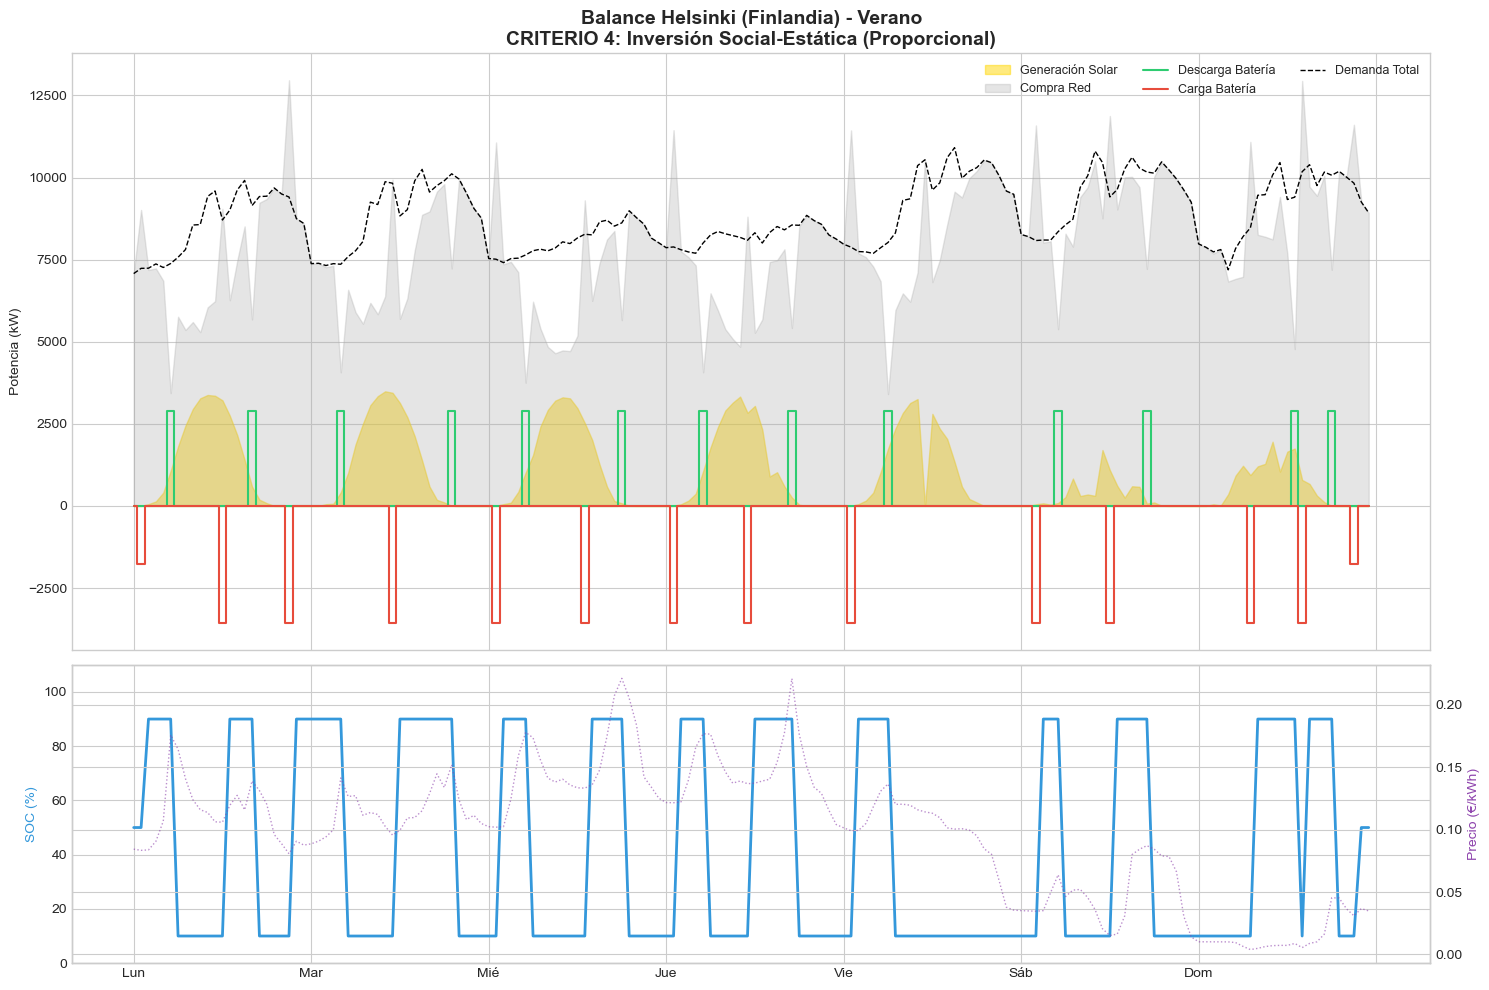

Archivo guardado: Analisis_Helsinki_Verano.png


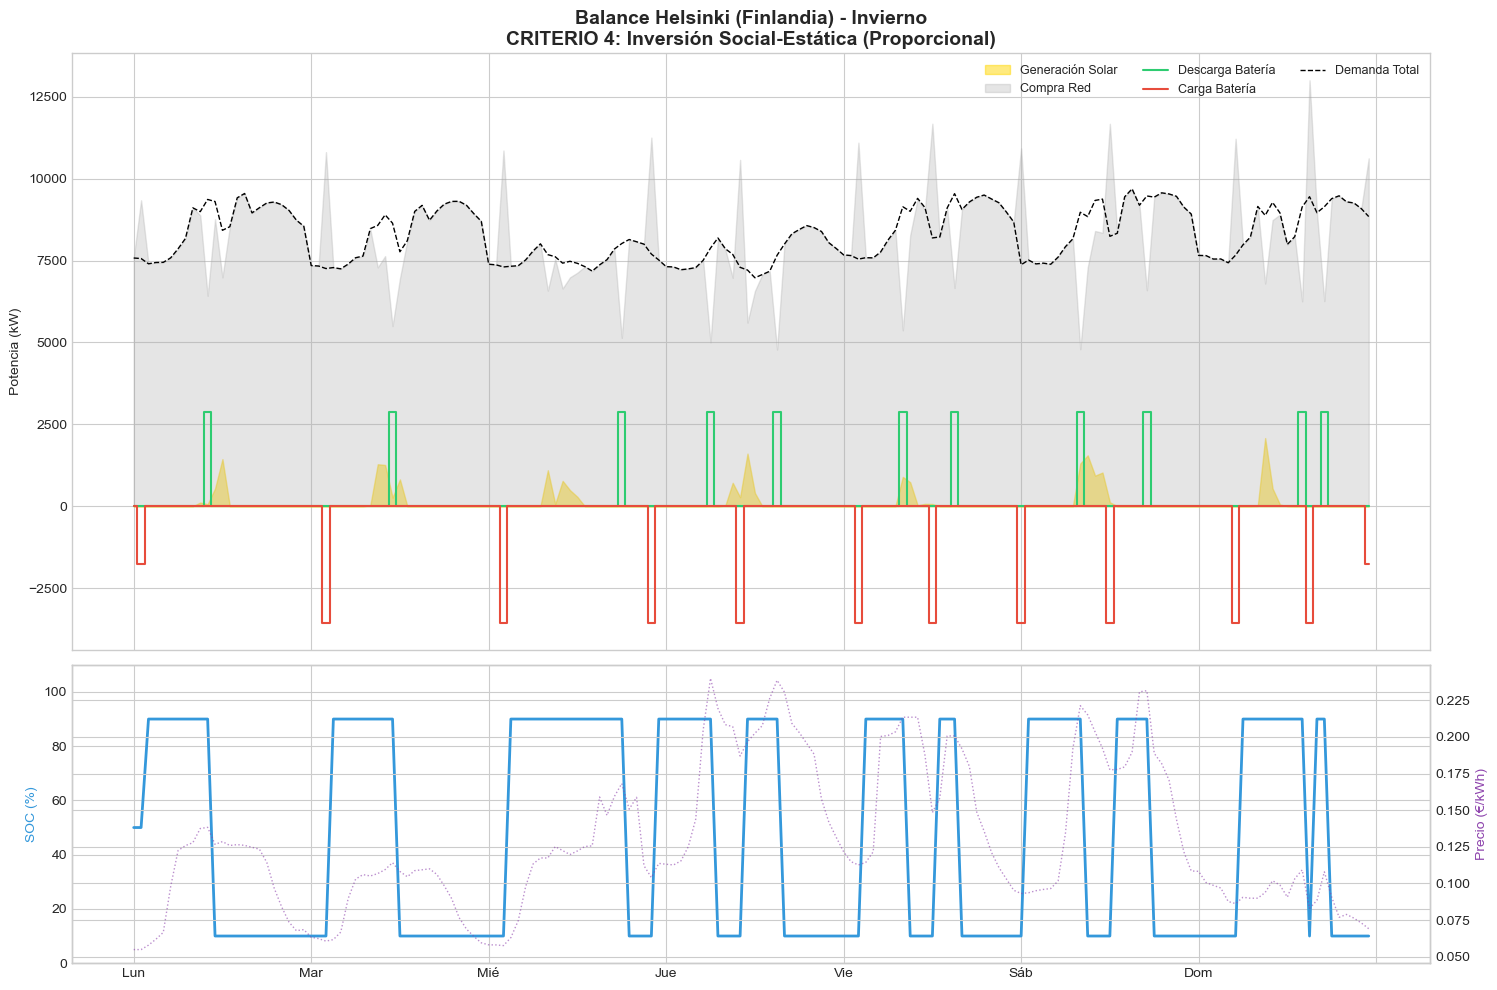

Archivo guardado: Analisis_Helsinki_Invierno.png


In [39]:
def guardar_graficos_finales(modelo, ubicacion_nombre, estaciones=["Verano", "Invierno"], criterio_nombre=""):
    # Limpiar el nombre de la ubicación para el nombre del archivo
    loc_clean = ubicacion_nombre.split(" (")[0].replace(" ", "_")
    
    for s in estaciones:
        plt.style.use('seaborn-v0_8-whitegrid')
        horas = np.arange(168)
        
        # 1. Extracción de datos (Totales de la comunidad)
        p_pv_total = pyo.value(modelo.pSizePV_tejados + modelo.pSizePV_suelo)
        solar = [p_pv_total * pyo.value(modelo.pFV[s, i]) for i in horas]
        demanda = [sum(pyo.value(modelo.pDemanda[s, i, c]) for c in modelo.sCons) for i in horas]
        compra = [sum(pyo.value(modelo.vXcompra[s, i, c]) for c in modelo.sCons) for i in horas]
        descarga = [sum(pyo.value(modelo.vXdescarga[s, i, c]) for c in modelo.sCons) for i in horas]
        carga = [-sum(pyo.value(modelo.vXcarga[s, i, c]) for c in modelo.sCons) for i in horas]
        
        soc_perc = [(pyo.value(modelo.vSOC[s, i]) / pyo.value(modelo.pSizeESS)) * 100 for i in horas]
        precios = [pyo.value(modelo.pPrecioTotal[s, i]) for i in horas]

        # 2. Creación de la figura
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, 
                                       gridspec_kw={'height_ratios': [2, 1]})

        # PANEL 1: Potencias
        ax1.fill_between(horas, solar, label='Generación Solar', color='#FFD700', alpha=0.5)
        ax1.fill_between(horas, compra, label='Compra Red', color='#A9A9A9', alpha=0.3)
        ax1.step(horas, descarga, where='mid', label='Descarga Batería', color='#2ECC71', lw=1.5)
        ax1.step(horas, carga, where='mid', label='Carga Batería', color='#E74C3C', lw=1.5)
        ax1.plot(horas, demanda, label='Demanda Total', color='black', lw=1, linestyle='--')
        ax1.set_ylabel('Potencia (kW)')
        ax1.set_title(f'Balance {ubicacion_nombre} - {s}\n{criterio_nombre}', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper right', ncol=3, fontsize=9)

        # PANEL 2: SOC y Precio
        ax2.plot(horas, soc_perc, color='#3498DB', label='SOC Batería (%)', lw=2)
        ax2.set_ylabel('SOC (%)', color='#3498DB')
        ax2.set_ylim(0, 110)
        ax3 = ax2.twinx()
        ax3.plot(horas, precios, color='#8E44AD', label='Precio Energía', lw=1, alpha=0.6, linestyle=':')
        ax3.set_ylabel('Precio (€/kWh)', color='#8E44AD')
        
        ax2.set_xticks(np.arange(0, 169, 24))
        ax2.set_xticklabels(['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom', ''])
        
        # Guardar PNG directamente
        filename = f"Analisis_{loc_clean}_{s}.png"
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.show() # Lo mostramos también para confirmar
        print(f"Archivo guardado: {filename}")

# Ejecución
guardar_graficos_finales(model, nombre_ubicacion, ["Verano", "Invierno"], nombre_actual)

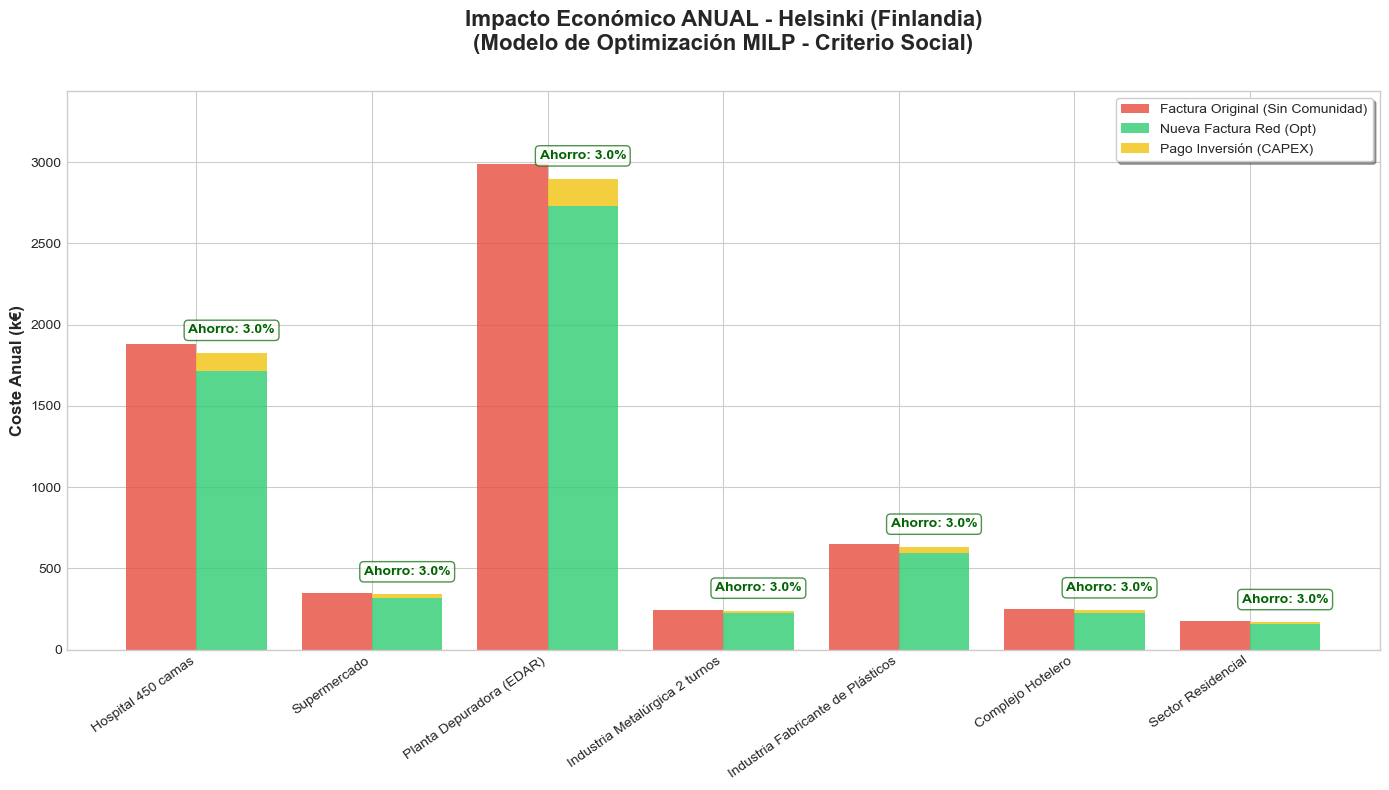

Gráfico profesional guardado como: Impacto_Economico_Anual_Helsinki.png


In [40]:
def graficar_impacto_anual_pro(modelo, mapeo_nombres, ubicacion):
    # 1. Preparación de datos
    consumidores = list(modelo.sCons)
    nombres_legibles = [mapeo_nombres.get(c, c) for c in consumidores]
    
    # Coste de inversión anual total
    coste_inv_anual_total = (
        pyo.value(modelo.pSizePV_tejados) * pyo.value(coste_anual_pv_val) + 
        pyo.value(modelo.pSizePV_suelo) * pyo.value(coste_anual_pv_suelo_val) + 
        pyo.value(modelo.pSizeESS) * pyo.value(coste_anual_ess_val)
    )

    factura_base_anual = []
    factura_red_opt_anual = []
    pago_inv_anual_indiv = []

    for c in consumidores:
        factura_base_anual.append(factura_base_individual[c] * 52)
        
        f_op_sem = sum(
            pyo.value(modelo.vXcompra[s, i, c]) * pyo.value(modelo.pPrecioTotal[s, i]) - 
            pyo.value(modelo.vXventa[s, i, c]) * ((0.5 * pyo.value(modelo.pPrecioMercado[s, i]) * 0.93) - 0.0005)
            for s in modelo.sEst for i in modelo.sInt
        ) / 4
        factura_red_opt_anual.append(f_op_sem * 52)
        pago_inv_anual_indiv.append(coste_inv_anual_total * pyo.value(modelo.vCuotaInv[c]))

    # 2. Configuración del gráfico
    x = np.arange(len(nombres_legibles))
    width = 0.4
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))
    
    scale = 1000 # Pasar a k€
    barra_base = [v/scale for v in factura_base_anual]
    barra_red = [v/scale for v in factura_red_opt_anual]
    barra_inv = [v/scale for v in pago_inv_anual_indiv]
    barra_total_nueva = [r + i for r, i in zip(barra_red, barra_inv)]

    ax.bar(x - width/2, barra_base, width, label='Factura Original (Sin Comunidad)', color='#E74C3C', alpha=0.8)
    ax.bar(x + width/2, barra_red, width, label='Nueva Factura Red (Opt)', color='#2ECC71', alpha=0.8)
    ax.bar(x + width/2, barra_inv, width, bottom=barra_red, label='Pago Inversión (CAPEX)', color='#F1C40F', alpha=0.8)

    # 3. Estética y corrección de márgenes
    ax.set_ylabel('Coste Anual (k€)', fontsize=12, fontweight='bold')
    ax.set_title(f'Impacto Económico ANUAL - {ubicacion}\n(Modelo de Optimización MILP - Criterio Social)', 
                 fontsize=16, fontweight='bold', pad=30)
    
    # Aumentamos el límite superior un 15% para que las etiquetas no choquen con el borde
    ax.set_ylim(0, max(barra_base) * 1.15) 
    
    ax.set_xticks(x)
    ax.set_xticklabels(nombres_legibles, rotation=35, ha='right', fontsize=10)
    ax.legend(loc='upper right', frameon=True, shadow=True)

    # Etiquetas de ahorro (Corregidas: positivas y con más margen)
    for i in range(len(consumidores)):
        total_inicial = factura_base_anual[i]
        total_final = factura_red_opt_anual[i] + pago_inv_anual_indiv[i]
        ahorro_perc = 100 * (1 - total_final / total_inicial)
        
        # Dibujamos la etiqueta sobre la barra optimizada (barra total nueva)
        ax.annotate(f'Ahorro: {ahorro_perc:.1f}%', 
                    xy=(x[i] + width/2, barra_total_nueva[i]),
                    xytext=(0, 12), # Aumentamos el offset vertical a 12
                    textcoords="offset points",
                    ha='center', va='bottom', 
                    fontweight='bold', color='darkgreen', 
                    fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='darkgreen', alpha=0.7))

    plt.tight_layout()
    
    # Guardar en PNG
    loc_clean = ubicacion.split(" (")[0].replace(" ", "_")
    nombre_archivo = f"Impacto_Economico_Anual_{loc_clean}.png"
    plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Gráfico profesional guardado como: {nombre_archivo}")

# Ejecutar para la ubicación actual
graficar_impacto_anual_pro(model, mapeo_nombres, nombre_ubicacion)